In [27]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

model_name = "EmbeddingAndCNNModel"
# model_name = "EmbeddingAnd2dCNNModel"
target_feature = "endianness"
# target_feature = "instructionwidth_type"

In [28]:
# Specify the directory containing the CSV files
directory = "../../results/"  # Change this to your actual path
csv_files = glob.glob(os.path.join(directory, "*.csv"))
df = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)

# Filter on model and target feature
df = df[
    (df["model.name"] == model_name) & (df["target_feature"] == target_feature)
].reset_index(drop=True)

In [29]:
# Compute mean and std of overall accuracy
df_overall = df[df["Name"] == "overall_metrics"][["overall_accuracy"]]
overall_mean = df_overall["overall_accuracy"].mean()
overall_std = df_overall["overall_accuracy"].std()

# Remove unnecessary columns
df_filtered = df[["Name", "test_accuracy", "test_loss", "train_loss"]]

# Remove aggregation rows and rename columns
df_folds = df_filtered[df_filtered["Name"] != "overall_metrics"].rename(
    columns={"Name": "architecture"}
)

df_folds["architecture"] = df_folds["architecture"].str.removeprefix("fold_")

df_folds.head()

,architecture,test_accuracy,test_loss,train_loss
1,x32,0.999521,9.063290e-04,0.012843
2,sparc64,0.978327,1.603692e-01,0.012718
3,sparc,1.000000,1.452514e-04,0.013846
4,sh4,0.999663,6.120743e-03,0.013645
5,s390x,1.000000,1.812978e-07,0.013908


In [30]:
df_agg = (
    df_folds.groupby("architecture")
    .agg({"test_accuracy": ["mean", "std"]})
    .sort_values(("test_accuracy", "mean"), ascending=False)
    .reset_index()
)

df_agg

architecture test_accuracy          
                         mean       std
0       ppc64el      1.000000  0.000000
1    powerpcspe      0.999968  0.000089
2         s390x      0.999965  0.000100
3       powerpc      0.999862  0.000389
4           x32      0.999701  0.000492
5         sparc      0.999598  0.000480
6        mipsel      0.998576  0.001614
7          s390      0.998451  0.003209
8         amd64      0.996793  0.007291
9          i386      0.993569  0.008483
10        alpha      0.989963  0.020494
11        armel      0.988964  0.020982
12          sh4      0.980249  0.025862
13      sparc64      0.968750  0.016799
14        armhf      0.967674  0.021820
15      riscv64      0.957827  0.059284
16        ppc64      0.948994  0.080563
17     mips64el      0.938978  0.100674
18         mips      0.934202  0.067910
19         ia64      0.885003  0.036236
20         hppa      0.816829  0.144749
21        arm64      0.644939  0.309921
22         m68k      0.065325  0.122524

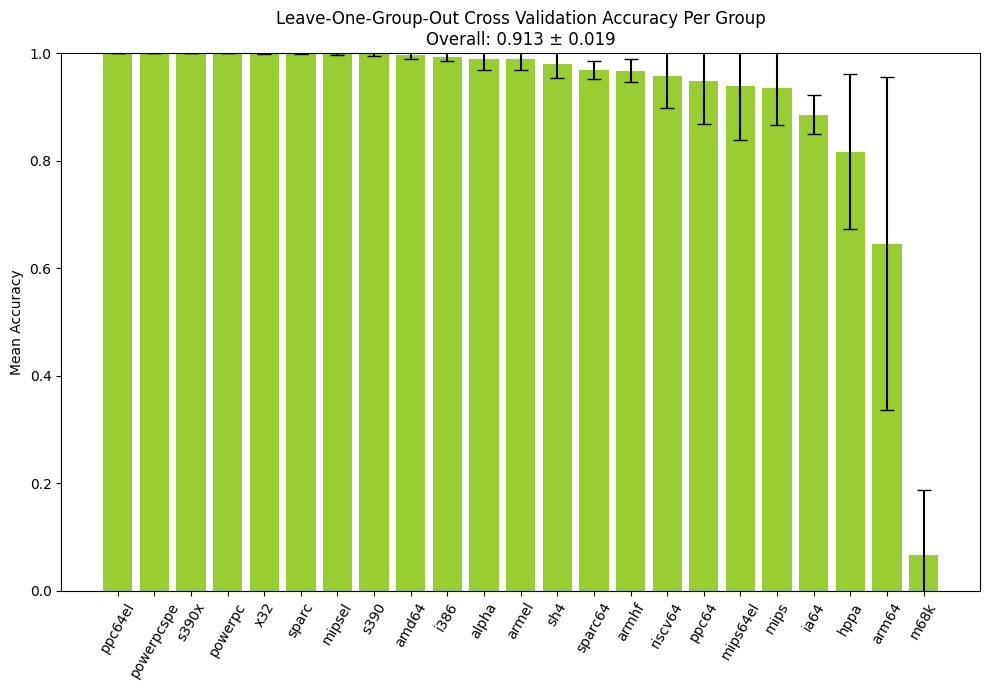

In [31]:
means = df_agg[("test_accuracy", "mean")].values
stds = df_agg[("test_accuracy", "std")].values
architectures = df_agg["architecture"].values

plt.figure(figsize=(10, 7))
bars = plt.bar(
    range(len(architectures)), means, yerr=stds, capsize=5, color="yellowgreen"
)

plt.xticks(range(len(architectures)), architectures, rotation=60)
plt.title(
    f"Leave-One-Group-Out Cross Validation Accuracy Per Group\nOverall: {overall_mean:.3f} ± {overall_std:.3f}"
)
plt.ylabel("Mean Accuracy")
plt.ylim(0, 1)

plt.tight_layout()